In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# training split, dev/validation split, test split
# 80%, 10%, 10%
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [41]:
# embedding layer, 27 characters to 2 dimensions
C = torch.randn((27, 2))
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [42]:
# hidden layer, 100 neurons
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [43]:
# use view to reshape the embedding output, concatenate the 3 2-dimensional vectors into a single 6-dimensional vector
# then do a linear transformation, then a non-linear activation function (tanh)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [12]:
h

tensor([[ 0.6343,  0.9965,  0.9544,  ..., -0.0290,  0.7658,  0.3811],
        [-0.7151,  0.9873,  0.9753,  ..., -0.7006,  0.2889,  0.9578],
        [-0.6208, -0.9946,  0.9907,  ..., -0.9993,  0.8987,  0.9977],
        ...,
        [ 0.8332,  0.9806,  0.8011,  ..., -0.8504,  0.4482, -0.9830],
        [-0.2783,  0.9995,  0.9935,  ..., -0.9938, -0.3179, -0.8821],
        [-0.9976,  0.9815,  0.8544,  ..., -0.9879, -0.9421,  0.2748]])

In [13]:
h.shape

torch.Size([228146, 100])

In [44]:
# softmax layer, 27 neurons
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [45]:
logits = h @ W2 + b2
# compute the loss
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# loss = -prob[torch.arange(228146), Y].log().mean()

# use cross_entropy from PyTorch, which combines log-softmax and nll-loss in one function
loss = F.cross_entropy(logits, Y)

In [46]:
for p in [C, W1, b1, W2, b2]:
        p.requires_grad = True

In [ ]:
# training loop
for _ in range(1000):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)

    # backward pass
    for p in [C, W1, b1, W2, b2]:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1
    for p in [C, W1, b1, W2, b2]:
        p.data += -lr * p.grad

    if _ % 100 == 0:
        print(loss.item())

15.69314193725586
3.6061911582946777
3.069369316101074
2.8768651485443115
2.776315212249756
2.71822190284729
2.679394245147705
2.6470346450805664
2.613149642944336
2.587681531906128


In [48]:
# iteratively train on minibatches of 32, faster than full-batch, roughly the same gradient direction as well as same result
batch_size = 32
for _ in range(1000):
    # create minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in [C, W1, b1, W2, b2]:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1
    for p in [C, W1, b1, W2, b2]:
        p.data += -lr * p.grad

    if _ % 100 == 0:
        print(loss.item())

2.600337266921997
2.5641870498657227
2.798398494720459
2.783745288848877
2.6247293949127197
2.6927261352539062
2.224393129348755
2.489394426345825
2.9264581203460693
2.4776856899261475


In [ ]:
# put it all together
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g) # embedding layer, 27 characters to 10 dimensions；more dimensions, more capacity.
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [50]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [75]:
for p in parameters:
  p.requires_grad = True

In [52]:
# line rate finder
lre = torch.linspace(-3, 0, 1000) # linear in exponential space
lrs = 10**lre # from 0.001 to 1

In [ ]:
# finding proper learning rate, usually between 0.001 to 0.1
# 1. gradually increase the learning rate
# 2. plot the loss vs learning rate in log-log scale

lri = []
lossi = []
stepi = []

for i in range(1000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = lrs[i]
  #lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

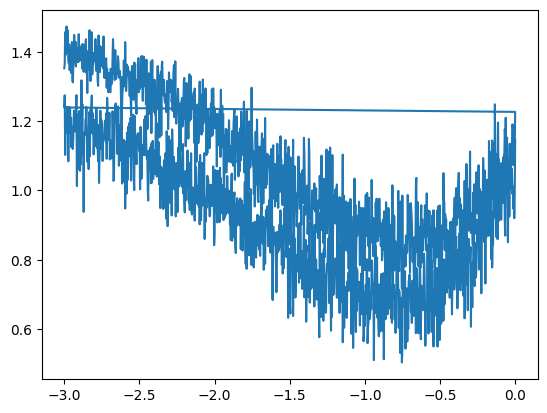

In [ ]:
plt.plot(lri, lossi)
# valley around -1.0 to -0.5, corresponding to learning rate 0.1 to 0.3, choose 0.1 as learning rate

In [76]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  if i % 1000 == 0:
    print(i, loss.item())


0 26.45479393005371
1000 3.8963942527770996
2000 3.4526302814483643
3000 2.2191357612609863
4000 2.5030789375305176
5000 2.448460578918457
6000 3.2482903003692627
7000 2.7343578338623047
8000 2.682762622833252
9000 2.1294095516204834
10000 2.363013744354248
11000 2.6262598037719727
12000 2.572620153427124
13000 2.303680181503296
14000 2.2222540378570557
15000 2.308669328689575
16000 2.551140308380127
17000 2.6269583702087402
18000 2.2888152599334717
19000 2.5196616649627686
20000 2.1752731800079346
21000 2.175544261932373
22000 1.9568064212799072
23000 2.6510446071624756
24000 3.033013343811035
25000 2.8687045574188232
26000 3.0626344680786133
27000 2.657564640045166
28000 2.034787178039551
29000 2.7063686847686768
30000 2.2750046253204346
31000 2.407927989959717
32000 2.0616085529327393
33000 2.4612221717834473
34000 2.4844725131988525
35000 2.255603790283203
36000 2.5110411643981934
37000 2.4428279399871826
38000 2.019404888153076
39000 2.2281129360198975
40000 2.9102141857147217
410

In [71]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1266, grad_fn=<NllLossBackward0>)

In [72]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1664, grad_fn=<NllLossBackward0>)

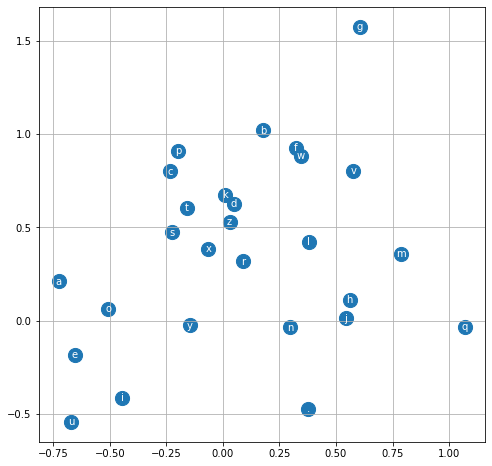

In [710]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

hyper parameters:
context size, embedding dimension, hidden neurons, training loops, learning rate

In [77]:


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1) # use softmax to convert to probabilities
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mohaalmyanna.
elme.
hayla.
rethruckadrie.
cadered.
eliah.
miloparekeiseananar.
elle.
malara.
nosadbergiairiel.
jenie.
jenelle.
pulmoura.
ged.
ryyah.
fael.
yuma.
myston.
mahia.
calyansuf.
